In [5]:
import tensorflow as tf
import sys, imageio, os
sys.path.append("/Users/kai/Downloads/graduation/code")
from models.config import *
from models.model import *
from models.data_prepare import *
import keras

/Users/kai/Downloads/graduation/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
X_train, X_test, y_train, y_test = data()

In [7]:
X_train[0].shape

(120,)

## Call back setting

https://keras.io/guides/writing_your_own_callbacks/

https://keras.io/guides/training_with_built_in_methods/ 

In [4]:
model_save_path = os.path.join(os.path.split(storage_path)[0],"models")

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        # "no longer improving" being defined as "no better than 1e-3 less"
        # "no longer improving" being further defined as "for at least 3 epochs"
        monitor="val_loss",
        min_delta=1e-3,
        patience=3,
        verbose=1),
    keras.callbacks.ModelCheckpoint(
        # Path for save the model
        # The two parameters below mean that we will overwrite the current checkpoint
        # if and only if the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath= model_save_path + "/model_test{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,),
]

In [9]:
model_save_path = os.path.join(os.path.split(storage_path)[0],"models")
model_save_path

'/Users/kai/Downloads/graduation/code/models'

## Load model

## Save structrue

## data_augmentation

https://www.tensorflow.org/tutorials/images/data_augmentation

https://www.tensorflow.org/guide/function


In [10]:
X_train

Array([[157, 157, 157, ..., 152, 152, 153],
       [184, 185, 187, ..., 187, 185, 184],
       [160, 162, 159, ..., 167, 165, 168],
       ...,
       [167, 166, 167, ..., 152, 152, 154],
       [193, 192, 191, ..., 191, 191, 193],
       [166, 167, 166, ..., 149, 149, 149]], dtype=uint8)

In [11]:
X_train.shape

(64, 120)

In [15]:
X_train_aug = data_aug(X_train)
X_train_aug

<tf.Tensor: shape=(64, 120, 1), dtype=float32, numpy=
array([[[152.82837],
        [151.82837],
        [151.82837],
        ...,
        [156.82837],
        [156.82837],
        [156.82837]],

       [[183.82837],
        [184.82837],
        [186.82837],
        ...,
        [186.82837],
        [184.82837],
        [183.82837]],

       [[167.82837],
        [164.82837],
        [166.82837],
        ...,
        [158.82837],
        [161.82837],
        [159.82837]],

       ...,

       [[153.82837],
        [151.82837],
        [151.82837],
        ...,
        [166.82837],
        [165.82837],
        [166.82837]],

       [[192.82837],
        [190.82837],
        [190.82837],
        ...,
        [190.82837],
        [191.82837],
        [192.82837]],

       [[148.82837],
        [148.82837],
        [148.82837],
        ...,
        [165.82837],
        [166.82837],
        [165.82837]]], dtype=float32)>

## compare the data aug with two different model 

It does not make sense to have huge difference of the MAE everytime. Try to use different tuner.

https://neptune.ai/blog/hyperband-and-bohb-understanding-state-of-the-art-hyperparameter-optimization-algorithms

## Try different tuner 

https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

### hyperband

Randomly sample all the combinations of hyperparameter and now instead of running full training and evaluation on it, train the model for few epochs (less than max_epochs) with these combinations and select the best candidates based on the results on these few epochs.

### Bayesian Optimization
Instead of all combinations being random, it chooses first few randomly, then based on the performance on these hyperparameters it chooses the next best possible hyperparameters. Hence it takes into account the history of the hyperparameters which were tried.

In [4]:
# https://towardsdatascience.com/tune-deep-neural-networks-using-bayesian-optimization-c9f6503a049f
def build_model_test(hp):
    input_size = hp.Fixed("input", 120)
    model = keras.Sequential()
    model.add(keras.layers.Rescaling(1 / 127.5, input_shape=(input_size, 1), offset=-1))
    # remove from 3 ->2 con for Bay
    for i in range(hp.Int("num_conv_layers", 1, 2, default=2)):
        model.add(keras.layers.Conv1D(
            filters=hp.Int(f"filters_{i + 1}", min_value=32, max_value=256, step=32),
            kernel_size=hp.Int(f"kernal_size_{i + 1}", min_value=5, max_value=20, sampling="log"),
            activation="relu",
            name=f"conv_{i + 1}",
            kernel_regularizer=keras.regularizers.L1(
                hp.Float("kernel_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            activity_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            bias_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log"))))
        model.add(keras.layers.Dropout(hp.Choice('dropout_'+ str(i), values=[0.0, 0.1, 0.2])))
        hp_padding=hp.Choice('padding_'+ str(i), values=['valid', 'same'])
        hp_pooling = hp.Choice(f'pooling_{i}', values=["MP", "AP", "No pool"])
        if hp_pooling == "MP":
            model.add(keras.layers.MaxPooling1D(2,padding=hp_padding))
        if hp_pooling == "AP":
            model.add(keras.layers.AveragePooling1D(2,padding=hp_padding))
        if hp.Boolean("batch_normalization", default=False):
            model.add(keras.layers.BatchNormalization())
    # model.add(keras.layers.Dropout(hp.Float("Dropout", min_value=0, max_value=0.2, step=0.1, default=0.2)))
    
    model.add(keras.layers.Flatten())
    for j in range(hp.Int("num_dense_layers", 1, 3, default=2)):
        model.add(keras.layers.Dense(
            units=hp.Int("dense_size", min_value=8, max_value=256, step=16), activation="relu",
            name=f"dense_{j + 1}",
            kernel_regularizer=keras.regularizers.L1(
                hp.Float("kernel_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            activity_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            bias_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log"))))
        model.add(keras.layers.Dropout(hp.Float(f"dropout_{i + 1}", 0, 0.5, step=0.1, default=0.2)))
    model.add(keras.layers.Dense(units=1, activation=None, name="output"))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", min_value=1e-5, max_value=1e-1, sampling="log", default=1e-3)),
        loss="mean_squared_error",
        metrics="mean_absolute_error")
    return model

In [5]:
# fix the padding part in this model
def build_model_CNN(hp):
    input_size = hp.Fixed("input", 120)
    model = keras.Sequential()
    model.add(keras.layers.Rescaling(1 / 127.5, input_shape=(input_size, 1), offset=-1))
    for i in range(hp.Int("num_conv_layers", 1, 2, default=2)):
        model.add(keras.layers.Conv1D(
            filters=hp.Int(f"filters_{i + 1}", min_value=32, max_value=256, step=32),
            kernel_size=hp.Int(f"kernal_size_{i + 1}", min_value=5, max_value=20, sampling="log"),
            activation="relu",
            name=f"conv_{i + 1}",
            kernel_regularizer=keras.regularizers.L1(
                hp.Float("kernel_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            activity_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            bias_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log"))))
        hp_pooling = hp.Choice(f'pooling_{i}', values=["MP", "AP", "No pool"])
        hp_padding = hp.Choice('padding_'+ str(i), values=['valid', 'same'])
        if hp_pooling == "MP":
            model.add(keras.layers.MaxPooling1D(hp.Int(f"MP_{i + 1}", min_value=1, max_value=3, step=1),padding = hp_padding))
        if hp_pooling == "AP":
            model.add(keras.layers.AveragePooling1D(hp.Int(f"AP_{i + 1}", min_value=1, max_value=3, step=1),padding = hp_padding))
        if hp.Boolean("batch_normalization", default=False):
            model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(hp.Float("Dropout", min_value=0, max_value=0.2, step=0.1, default=0.2)))
    model.add(keras.layers.Flatten())
    for j in range(hp.Int("num_dense_layers", 1, 3, default=2)):
        model.add(keras.layers.Dense(
            units=hp.Int("dense_size", min_value=8, max_value=256, step=16), activation="relu",
            name=f"dense_{j + 1}",
            kernel_regularizer=keras.regularizers.L1(
                hp.Float("kernel_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            activity_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            bias_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log"))))
        model.add(keras.layers.Dropout(hp.Float(f"dropout_{i + 1}", 0, 0.5, step=0.1, default=0.2)))
    model.add(keras.layers.Dense(units=1, activation=None, name="output"))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", min_value=1e-5, max_value=1e-1, sampling="log", default=1e-3)),
        loss="mean_squared_error",
        metrics="mean_absolute_error")
    return model

In [7]:
tuner_baye = kt.BayesianOptimization(
        build_model_CNN,
        objective="val_mean_absolute_error",
        max_trials=100,
        num_initial_points=50,
        alpha=0.0001,
        beta=2.6,
        seed=11,
        directory='.',
        project_name='tuning-cnn-add-test',
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,)
tuner_baye.search(
    X_train,
    y_train,
    validation_data = (X_test,y_test),
    epochs=100,
    callbacks= callbacks,
)

Trial 57 Complete [00h 00m 01s]
val_mean_absolute_error: 6.07828950881958

Best val_mean_absolute_error So Far: 1.4933865070343018
Total elapsed time: 00h 06m 36s

Search: Running Trial #58

Value             |Best Value So Far |Hyperparameter
120               |120               |input
1                 |1                 |num_conv_layers
256               |160               |filters_1
8                 |10                |kernal_size_1
0.1               |0.001566          |kernel_regulizer
1e-05             |0.00020644        |activity_regulizer
MP                |No pool           |pooling_0
same              |same              |padding_0
1                 |1                 |MP_1
False             |False             |batch_normalization
96                |128               |filters_2
12                |12                |kernal_size_2
No pool           |MP                |pooling_1
same              |same              |padding_1
1                 |2                 |MP_2
0.1       

2022-11-08 11:26:46.276559: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at save_restore_v2_ops.cc:160 : NOT_FOUND: ./tuning-cnn-add-test/trial_057/checkpoint_temp/part-00000-of-00001.data-00000-of-00001.tempstate2870445281032287151; No such file or directory


NotFoundError: ./tuning-cnn-add-test/trial_057/checkpoint_temp/part-00000-of-00001.data-00000-of-00001.tempstate2870445281032287151; No such file or directory [Op:SaveV2]

In [50]:
def evaluate_hp_model(model,X_train,y_train,X_test,y_test):
    best_model = model.get_best_models(1)[0]
    best_model_hp = model.get_best_hyperparameters(1)[0]
    model_output = model.hypermodel.build(best_model_hp)
    history = model_output.fit(X_train,y_train,epochs=120,batch_size=5,validation_data=(X_test,y_test)) 
    print(best_model.evaluate(X_test,y_test))
    print(best_model_hp.values)
    return best_model, best_model_hp, history

def evaluate_epoch(history,type="loss"):
    import matplotlib.pyplot as plt
    if type == "loss":
        plt.plot(history.history["loss"],label="Loss")
        plt.plot(history.history["val_loss"],label="Val_Loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.ylim(0, 20)
        plt.show()
    if type == "mae":
        plt.plot(history.history["mean_absolute_error"],label="MAE")
        plt.plot(history.history["val_mean_absolute_error"],label="Val_MAE")
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.show()
    return print(f'{type} epoch plot execute!')


In [54]:
best_model, best_model_hp, history = evaluate_hp_model(tuner_baye,X_train,y_train,X_test,y_test)

2022-11-04 11:15:39,298-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-11-04 11:15:39,301-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-11-04 11:15:39,303-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-11-04 11:15:39,305-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-11-04 11:15:39,306-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-11-04 11:15:39,307-[WARNI

In [53]:
tf.keras.utils.plot_model(best_model)

AttributeError: module 'keras.utils' has no attribute 'plot_model'

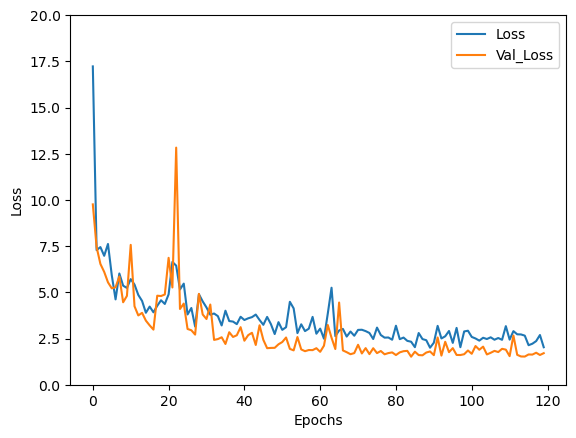

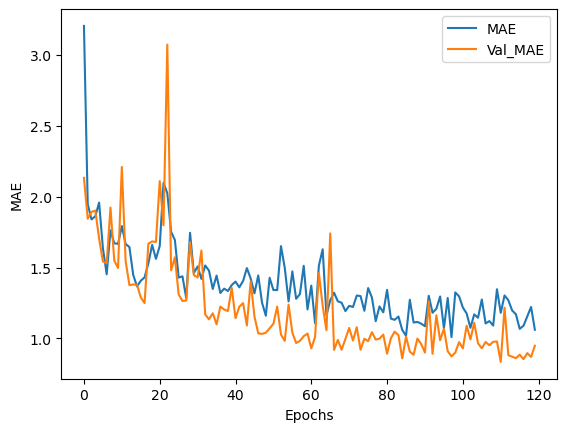

'mae epoch plot execute!'

In [49]:
evaluate_epoch(history,type="loss")
evaluate_epoch(history,type="mae")

In [20]:
tuner_baye_aug = kt.BayesianOptimization(
        build_model_CNN,
        objective="val_mean_absolute_error",
        max_trials=100,
        num_initial_points=2,
        alpha=0.0001,
        beta=2.6,
        seed=11,
        directory='.',
        project_name='tuning-cnn-aug',
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,)
tuner_baye_aug.search(
    X_train_aug,
    y_train,
    validation_data = (X_test,y_test),
    epochs=100,
    callbacks= callbacks,
)

Trial 100 Complete [00h 00m 01s]
val_mean_absolute_error: 1.5551096200942993

Best val_mean_absolute_error So Far: 1.48276686668396
Total elapsed time: 00h 12m 04s
INFO:tensorflow:Oracle triggered exit
2022-11-04 10:11:12,233-[INFO]- tensorflow:14 -> Oracle triggered exit


2022-11-04 11:06:57,233-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-11-04 11:06:57,234-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-11-04 11:06:57,234-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-11-04 11:06:57,235-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-11-04 11:06:57,236-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-11-04 11:06:57,236-[WARNI

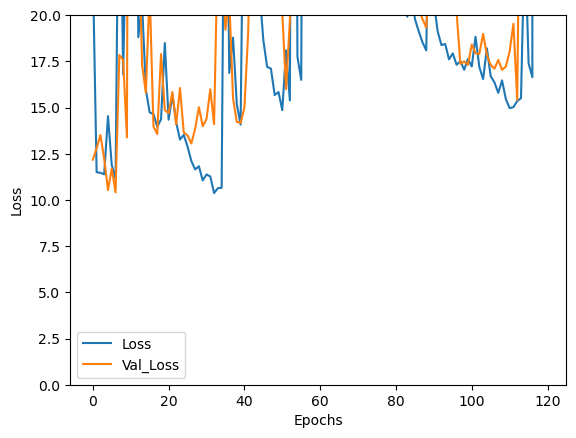

loss epoch plot execute!


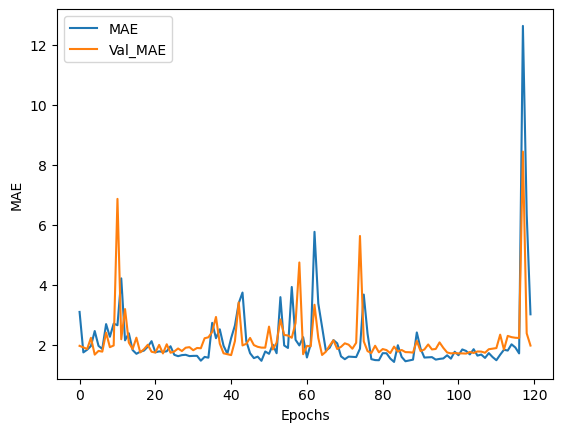

mae epoch plot execute!


In [52]:
best_model, best_model_hp, history = evaluate_hp_model(tuner_baye_aug,X_train_aug,y_train,X_test,y_test)
evaluate_epoch(history,type="loss")
evaluate_epoch(history,type="mae")

In [61]:
# https://jmlr.org/papers/volume18/16-558/16-558.pdf
# Hyperband is 5× to 30× faster than popular Bayesian optimization algorithms on a variety of deep-learning and kernel-based learning problems
tuner_hb = kt.Hyperband(
        build_model_CNN,
        objective="val_mean_absolute_error",
        seed=11,
        overwrite=True,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,)
tuner_hb.search(
    X_train,
    y_train,
    validation_data = (X_test,y_test),
    epochs=100,
    callbacks= callbacks,
)
# 1.3139036893844604

Trial 254 Complete [00h 00m 13s]
val_mean_absolute_error: 2.30522084236145

Best val_mean_absolute_error So Far: 1.3319530487060547
Total elapsed time: 00h 09m 42s
INFO:tensorflow:Oracle triggered exit
2022-11-05 10:10:56,754-[INFO]- tensorflow:11 -> Oracle triggered exit


In [63]:
my_best_model_hb = tuner_hb.get_best_models(1)[0]
my_best_model_hb.evaluate(X_test, y_test)
# 1.3139036893844604

2022-11-05 10:11:18,953-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-11-05 10:11:18,954-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-11-05 10:11:18,955-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-11-05 10:11:18,955-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-11-05 10:11:18,956-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-11-05 10:11:18,957-[WARNI

[5.399084568023682, 1.3319530487060547]

Epoch 1/120
13/13 [==============================] - 1s 42ms/step - loss: 13.3483 - mean_absolute_error: 2.7416 - val_loss: 9.5356 - val_mean_absolute_error: 2.0371
Epoch 2/120
13/13 [==============================] - 0s 16ms/step - loss: 8.3301 - mean_absolute_error: 2.0845 - val_loss: 6.7246 - val_mean_absolute_error: 1.6235
Epoch 3/120
13/13 [==============================] - 0s 19ms/step - loss: 7.8842 - mean_absolute_error: 1.8203 - val_loss: 7.3086 - val_mean_absolute_error: 1.7801
Epoch 4/120
13/13 [==============================] - 0s 18ms/step - loss: 6.4590 - mean_absolute_error: 1.6954 - val_loss: 4.9083 - val_mean_absolute_error: 1.4979
Epoch 5/120
13/13 [==============================] - 0s 15ms/step - loss: 7.7743 - mean_absolute_error: 2.0020 - val_loss: 5.1632 - val_mean_absolute_error: 1.5322
Epoch 6/120
13/13 [==============================] - 0s 15ms/step - loss: 6.4501 - mean_absolute_error: 1.8119 - val_loss: 6.3132 - val_mean_absolute_error: 1.6483
Epoch 7/120
13/

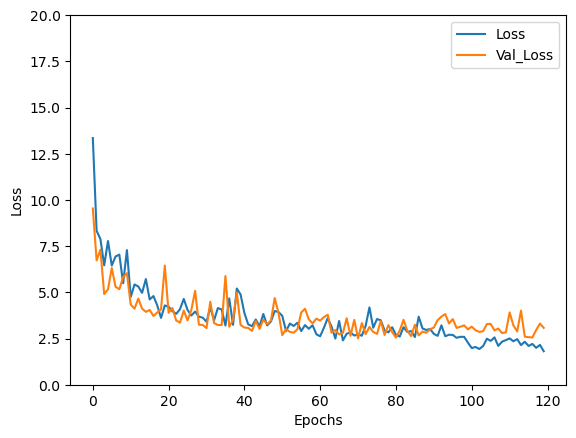

loss epoch plot execute!


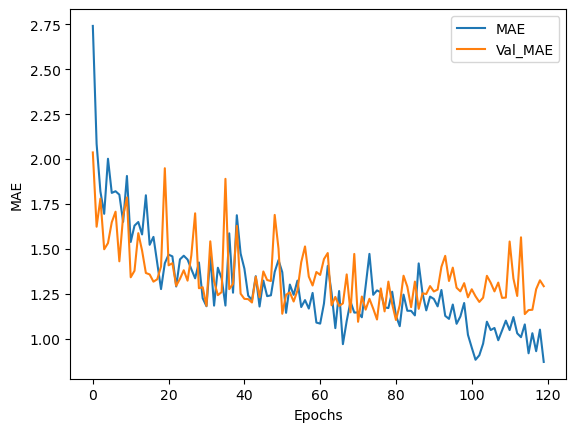

mae epoch plot execute!


In [62]:
best_model, best_model_hp, history = evaluate_hp_model(tuner_hb,X_train,y_train,X_test,y_test)
evaluate_epoch(history,type="loss")
evaluate_epoch(history,type="mae")

In [27]:
tuner_hb_aug = kt.Hyperband(
        build_model_CNN,
        objective="val_mean_absolute_error",
        seed=11,
        overwrite=True,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,)
tuner_hb_aug.search(
    X_train_aug,
    y_train,
    validation_data = (X_test,y_test),
    epochs=100,
    callbacks= callbacks,
)
# 1.4111642837524414

Trial 254 Complete [00h 00m 10s]
val_mean_absolute_error: 2.2925634384155273

Best val_mean_absolute_error So Far: 1.4111642837524414
Total elapsed time: 00h 08m 18s
INFO:tensorflow:Oracle triggered exit
2022-11-04 10:35:04,300-[INFO]- tensorflow:9 -> Oracle triggered exit


In [28]:
my_best_model_hb_aug = tuner_hb_aug.get_best_models(1)[0]
my_best_model_hb_aug.evaluate(X_test, y_test)
# 1.4112

2/2 [==============================] - 0s 4ms/step - loss: 7.9040 - mean_absolute_error: 1.4112


[7.9039812088012695, 1.4111642837524414]

2022-11-05 09:59:15,723-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-11-05 09:59:15,724-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-11-05 09:59:15,724-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-11-05 09:59:15,725-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-11-05 09:59:15,725-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-11-05 09:59:15,726-[WARNI

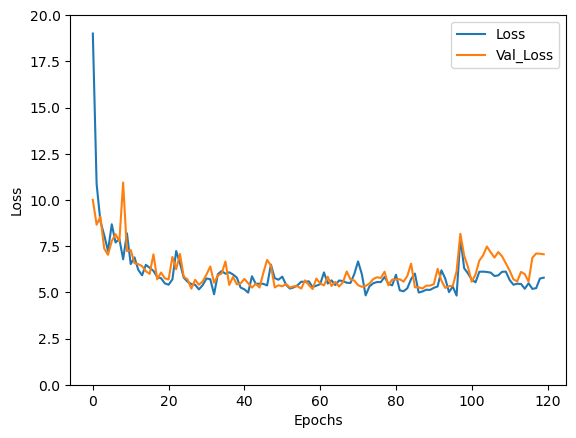

loss epoch plot execute!


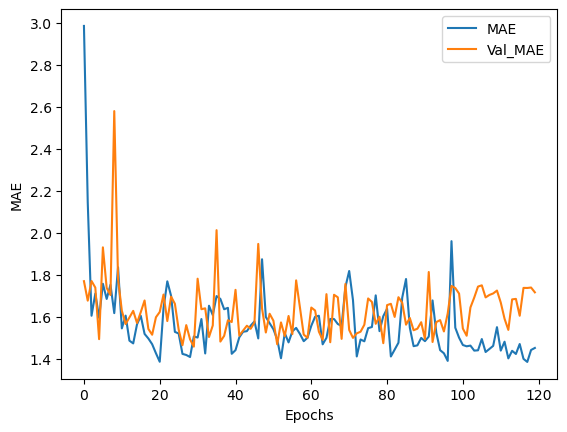

mae epoch plot execute!


In [60]:
best_model, best_model_hp, history = evaluate_hp_model(tuner_hb_aug,X_train,y_train,X_test,y_test)
evaluate_epoch(history,type="loss")
evaluate_epoch(history,type="mae")